In [2]:
# --- 1. CORE LIBRARIES ---
import pandas as pd  # Untuk manipulasi data tabular (DataFrame)
import numpy as np   # Untuk operasi numerik dan matriks

# --- 2. VISUALIZATION LIBRARIES ---
import matplotlib.pyplot as plt  # Library visualisasi dasar
import seaborn as sns            # Wrapper matplotlib agar grafik lebih estetik
# Mengatur style visualisasi agar standar akademis (bersih)
sns.set(style="whitegrid") 

# --- 3. NLP & TEXT PROCESSING ---
import re  # Regular Expressions untuk pembersihan teks (hapus simbol, dll)
import nltk # Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# --- 4. MACHINE LEARNING (SCIKIT-LEARN) ---
from sklearn.model_selection import train_test_split # Untuk membagi data validasi
from sklearn.feature_extraction.text import TfidfVectorizer # Mengubah teks jadi angka
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 5. KONFIGURASI REPRODUCIBILITY (PENTING!) ---
# Menetapkan seed agar hasil eksperimen konsisten setiap kali dijalankan
RANDOM_SEED = 42 
np.random.seed(RANDOM_SEED)

# Konfigurasi tampilan pandas agar kolom teks panjang terbaca
pd.set_option('display.max_colwidth', 200)

print("Environment siap! Library berhasil di-load.")

Environment siap! Library berhasil di-load.


In [3]:
# Ganti path sesuai lokasi file Anda
file_path = 'sentimentdataset.csv' 

# Load data
try:
    df = pd.read_csv(file_path)
    print("Data berhasil dimuat!")
except FileNotFoundError:
    print("File tidak ditemukan. Pastikan path sudah benar.")

# Inspeksi Awal (Best Practice)
print(f"Dimensi Data: {df.shape[0]} baris, {df.shape[1]} kolom")
print("\n--- 5 Baris Pertama ---")
display(df.head())

print("\n--- Info Tipe Data & Missing Values ---")
print(df.info())

print("\n--- Distribusi Target (Sentiment) ---")
# Ini krusial untuk tahu apakah data imbalanced
print(df['Sentiment'].value_counts())

Data berhasil dimuat!
Dimensi Data: 732 baris, 15 kolom

--- 5 Baris Pertama ---


,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park!,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning.,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway!,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight.,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19



--- Info Tipe Data & Missing Values ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB
None

--- Distribusi Target (Sentiment) ---
Sentiment
Positi

In [4]:
# 1. Load Dataset
df = pd.read_csv('sentimentdataset.csv')

# 2. Hapus kolom index bawaan yang tidak berguna ('Unnamed: 0')
# Alasannya: Kita sudah punya index dari Pandas, kolom ini cuma sampah (noise).
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# 3. Masalah Utama: WHITESPACE CLEANING
# Logika: Kita loop semua kolom yang bertipe teks (object), lalu kita 'strip' (hapus spasi ujungnya).
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

# 4. Cek ulang data
print("Sampel data setelah dibersihkan:")
display(df.head(3))

# 5. Cek Label Sentimen (Target Variable)
print("\n--- Cek Unik Value pada Kolom Sentiment ---")
print(f"Jumlah label unik: {df['Sentiment'].nunique()}")
print(df['Sentiment'].value_counts().head(10))

Sampel data setelah dibersihkan:


,Unnamed: 0.1,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,Enjoying a beautiful day at the park!,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,Traffic was terrible this morning.,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,Just finished an amazing workout! 💪,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15



--- Cek Unik Value pada Kolom Sentiment ---
Jumlah label unik: 191
Sentiment
Positive       45
Joy            44
Excitement     37
Contentment    19
Neutral        18
Gratitude      18
Curiosity      16
Serenity       15
Happy          14
Nostalgia      11
Name: count, dtype: int64


In [5]:
import pandas as pd

# Memuat dataset
# Pastikan file 'sentimentdataset.csv' ada di folder yang sama dengan notebook ini
df = pd.read_csv('sentimentdataset.csv')

# Menampilkan 5 baris teratas untuk "mengintip" isi data
display(df.head())

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park!,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning.,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway!,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight.,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [6]:
# Cek dimensi (baris, kolom)
print(f"Dimensi Dataset: {df.shape}")
print(f"Jumlah Baris (Sampel): {df.shape[0]}")
print(f"Jumlah Kolom (Fitur): {df.shape[1]}")

Dimensi Dataset: (732, 15)
Jumlah Baris (Sampel): 732
Jumlah Kolom (Fitur): 15


In [7]:
# Audit tipe data dan memori
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [8]:
# 1. Kolom FITUR UTAMA (X) - Input untuk NLP
target_text_col = 'Text' 

# 2. Kolom TARGET (y) - Label yang akan diprediksi
target_label_col = 'Sentiment'

# 3. Kolom PENDUKUNG (Auxiliary Features) - Untuk Analisis Tambahan (EDA)
numerical_cols = ['Likes', 'Retweets', 'User_Followers', 'Engagement']
metadata_cols = ['Platform', 'Country', 'Timestamp', 'Hashtags']

print(f"Fitur NLP: {target_text_col}")
print(f"Target Prediksi: {target_label_col}")
print(f"Fitur Numerik Pendukung: {numerical_cols}")

Fitur NLP: Text
Target Prediksi: Sentiment
Fitur Numerik Pendukung: ['Likes', 'Retweets', 'User_Followers', 'Engagement']


In [9]:
# 1. Menghapus kolom 'Unnamed: 0' karena itu hanya duplikasi index (tidak berguna)
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# 2. Membersihkan Whitespace (Spasi Kosong)
# Masalah: " Positive " != "Positive"
# Solusi: Kita lakukan 'strip()' pada semua kolom bertipe teks (object)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

print("Pembersihan spasi selesai!")

# 3. Cek Inkonsistensi Label Sentimen
# Kita lihat ada berapa banyak variasi label "aneh" di data ini
print(f"\nJumlah Label Unik di kolom Sentiment: {df['Sentiment'].nunique()}")
print("Daftar 20 Label Terbanyak:")
print(df['Sentiment'].value_counts().head(20))

Pembersihan spasi selesai!

Jumlah Label Unik di kolom Sentiment: 191
Daftar 20 Label Terbanyak:
Sentiment
Positive       45
Joy            44
Excitement     37
Contentment    19
Neutral        18
Gratitude      18
Curiosity      16
Serenity       15
Happy          14
Nostalgia      11
Despair        11
Grief           9
Awe             9
Sad             9
Hopeful         9
Loneliness      9
Embarrassed     8
Acceptance      8
Confusion       8
Euphoria        7
Name: count, dtype: int64


In [10]:
# --- AUDIT KUALITAS DATA ---

# 1. Cek Missing Values (Data Kosong) per kolom
print("--- [1] Statistik Missing Values ---")
print(df.isnull().sum())

# 2. Cek Duplikasi Data (Baris yang sama persis)
duplicate_count = df.duplicated().sum()
print(f"\n--- [2] Jumlah Data Duplikat: {duplicate_count} baris ---")

# 3. Cek Inkonsistensi Teks (Contoh: Teks kosong tapi tidak NaN, hanya spasi)
# Kadang data tidak terbaca NaN, tapi isinya cuma string kosong "" atau spasi " "
empty_text_mask = df['Text'].str.strip() == ""
print(f"\n--- [3] Jumlah Teks 'Ghost' (Hanya Spasi/Kosong): {empty_text_mask.sum()} baris ---")

--- [1] Statistik Missing Values ---
Unnamed: 0.1    0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64

--- [2] Jumlah Data Duplikat: 0 baris ---

--- [3] Jumlah Teks 'Ghost' (Hanya Spasi/Kosong): 0 baris ---


In [11]:
# --- EKSEKUSI PEMBERSIHAN DATA ---

# Simpan jumlah data awal untuk laporan
initial_rows = df.shape[0]

# 1. Menghapus Duplikat
df.drop_duplicates(inplace=True)

# 2. Menghapus Baris jika Text ATAU Sentiment kosong (NaN)
df.dropna(subset=['Text', 'Sentiment'], inplace=True)

# 3. Menghapus Baris jika Text isinya hanya spasi (Ghost Text)
df = df[df['Text'].str.strip() != ""]

# 4. Handling Nilai Numerik (Isi NaN dengan 0)
cols_numeric = ['Likes', 'Retweets', 'User_Followers', 'Engagement']
# Hanya isi jika kolom tersebut ada di dataset
existing_num_cols = [c for c in cols_numeric if c in df.columns]
df[existing_num_cols] = df[existing_num_cols].fillna(0)

# --- LAPORAN AKHIR ---
final_rows = df.shape[0]
deleted_rows = initial_rows - final_rows

print(f"Data Awal    : {initial_rows} baris")
print(f"Data Akhir   : {final_rows} baris")
print(f"Data Dibuang : {deleted_rows} baris ({deleted_rows/initial_rows*100:.2f}%)")

# Cek ulang apakah sudah bersih
print("\nSisa Missing Values:")
print(df.isnull().sum())

Data Awal    : 732 baris
Data Akhir   : 732 baris
Data Dibuang : 0 baris (0.00%)

Sisa Missing Values:
Unnamed: 0.1    0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64


In [12]:
# Fungsi untuk memetakan emosi ke polaritas standar
def map_sentiment(label):
    label = str(label).lower().strip()
    
    # Daftar kata kunci
    positive_keywords = ['positive', 'happy', 'joy', 'excitement', 'love', 'grateful', 'enthusiasm']
    negative_keywords = ['negative', 'sad', 'anger', 'fear', 'grief', 'hate', 'disgust', 'terrible']
    
    # Logika mapping sederhana
    if any(k in label for k in positive_keywords):
        return 'Positive'
    elif any(k in label for k in negative_keywords):
        return 'Negative'
    else:
        return 'Neutral' # Default untuk label lain atau 'Neutral'

# Terapkan fungsi ke kolom Sentiment
df['Sentiment_Class'] = df['Sentiment'].apply(map_sentiment)

# Cek hasilnya
print("Distribusi Label Setelah Mapping:")
print(df['Sentiment_Class'].value_counts())

Distribusi Label Setelah Mapping:
Sentiment_Class
Neutral     528
Positive    162
Negative     42
Name: count, dtype: int64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13620\3532927212.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Class', data=df, palette='viridis', order=['Negative', 'Neutral', 'Positive'])


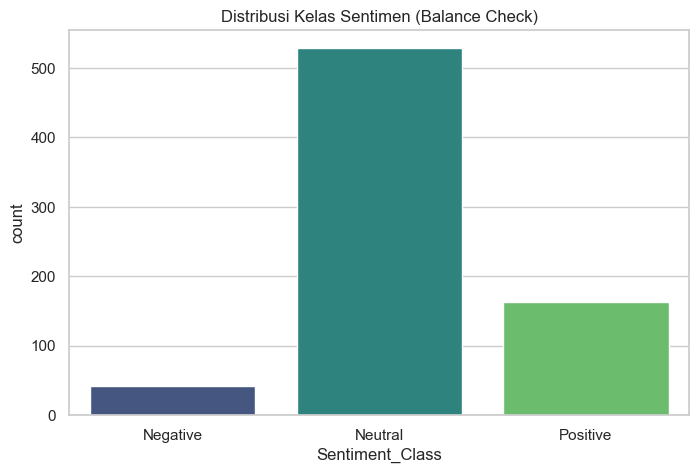

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment_Class', data=df, palette='viridis', order=['Negative', 'Neutral', 'Positive'])
plt.title('Distribusi Kelas Sentimen (Balance Check)')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13620\3768074086.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment_Class', y='Total_Engagement', data=df, estimator='mean', errorbar=None, palette='rocket')


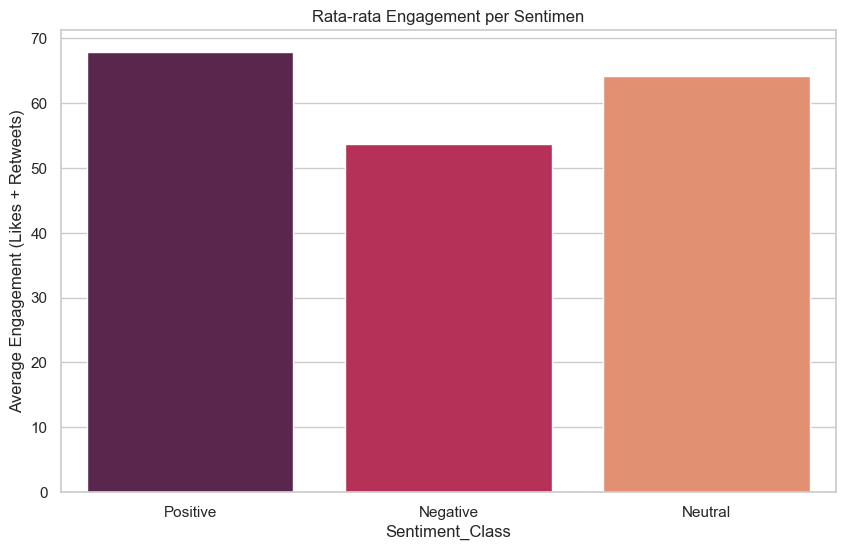

In [14]:
# Menghitung total engagement
# Pastikan kolom Likes/Retweets sudah numerik (dari tahap cleaning sebelumnya)
df['Total_Engagement'] = df['Likes'] + df['Retweets']

plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment_Class', y='Total_Engagement', data=df, estimator='mean', errorbar=None, palette='rocket')
plt.title('Rata-rata Engagement per Sentimen')
plt.ylabel('Average Engagement (Likes + Retweets)')
plt.show()

<Figure size 1200x600 with 0 Axes>

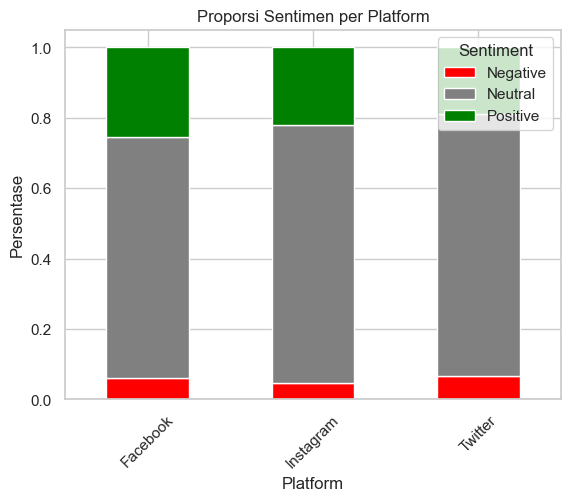

In [15]:
plt.figure(figsize=(12, 6))
# Crosstab untuk melihat proporsi
pd.crosstab(df['Platform'], df['Sentiment_Class'], normalize='index').plot(kind='bar', stacked=True, color=['red', 'gray', 'green'])
plt.title('Proporsi Sentimen per Platform')
plt.ylabel('Persentase')
plt.xticks(rotation=45)
plt.legend(title='Sentiment', loc='upper right')
plt.show()

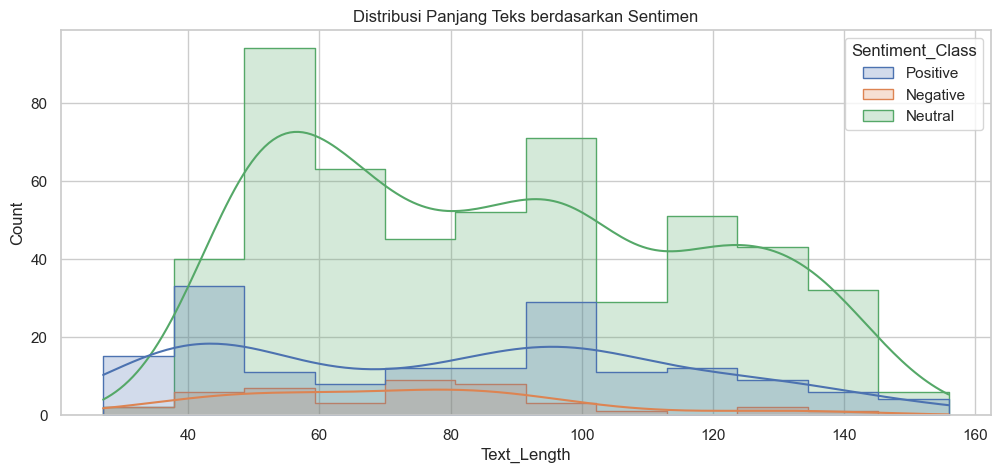

Rata-rata panjang karakter: 84.43
Panjang maksimum: 156


In [16]:
# Hitung panjang karakter setiap teks
df['Text_Length'] = df['Text'].apply(len)

plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='Text_Length', hue='Sentiment_Class', kde=True, element="step")
plt.title('Distribusi Panjang Teks berdasarkan Sentimen')
plt.show()

print(f"Rata-rata panjang karakter: {df['Text_Length'].mean():.2f}")
print(f"Panjang maksimum: {df['Text_Length'].max()}")

<Figure size 1400x600 with 0 Axes>

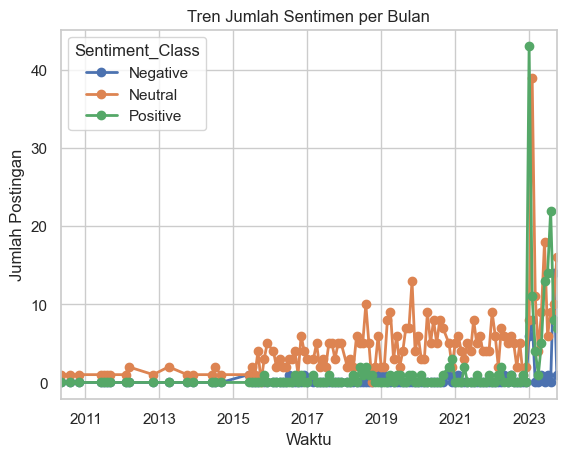

In [17]:
# Konversi Timestamp ke Datetime object
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Ekstrak Bulan-Tahun untuk agregasi
df['Month_Year'] = df['Timestamp'].dt.to_period('M')

# Agregasi data
trend_df = df.groupby(['Month_Year', 'Sentiment_Class']).size().unstack().fillna(0)

# Plotting
plt.figure(figsize=(14, 6))
trend_df.plot(kind='line', marker='o', linewidth=2)
plt.title('Tren Jumlah Sentimen per Bulan')
plt.ylabel('Jumlah Postingan')
plt.xlabel('Waktu')
plt.grid(True)
plt.show()

In [18]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 1. Download database bahasa (Hanya perlu run sekali)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') 

# 2. Setup Stopwords Khusus Sentimen
stop_words = set(stopwords.words('english'))

# DAFTAR KATA PENTING YANG TIDAK BOLEH DIHAPUS
# Kalau ini dihapus, makna kalimat akan berbalik arah
negation_words = {
    'no', 'not', 'nor', 'neither', 'never', 'none', 'cannot', 
    "don't", "aren't", "didn't", "wouldn't", "won't", "isn't", "wasn't"
}

# Hapus kata-kata di atas dari daftar 'sampah' (stopwords)
stop_words = stop_words - negation_words

# 3. Inisialisasi Lemmatizer
lemmatizer = WordNetLemmatizer()

def cleaning_pipeline(text):
    # a. Konversi ke string & huruf kecil
    text = str(text).lower()
    
    # b. Hapus URL, @username, dan karakter aneh
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text) # Hapus angka & tanda baca
    
    # c. Tokenisasi
    tokens = text.split()
    
    # d. Stopword Removal & Lemmatization
    clean_tokens = []
    for word in tokens:
        if word not in stop_words:
            # Ubah ke kata dasar (contoh: better -> good)
            lemma = lemmatizer.lemmatize(word, pos='v') 
            clean_tokens.append(lemma)
            
    return " ".join(clean_tokens)

# --- EKSEKUSI ---
print("Memulai preprocessing canggih...")
df['clean_text'] = df['Text'].apply(cleaning_pipeline)

# Cek hasil (Perhatikan kata 'not' jika ada, pasti masih tersimpan)
display(df[['Text', 'clean_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Memulai preprocessing canggih...


,Text,clean_text
0,Enjoying a beautiful day at the park!,enjoy beautiful day park
1,Traffic was terrible this morning.,traffic terrible morning
2,Just finished an amazing workout! 💪,finish amaze workout
3,Excited about the upcoming weekend getaway!,excite upcoming weekend getaway
4,Trying out a new recipe for dinner tonight.,try new recipe dinner tonight


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Definisikan X (Fitur) dan y (Target)
# Pastikan menggunakan kolom 'clean_text' hasil preprocessing terakhir
X = df['clean_text'] 
y = df['Sentiment_Class'] # Gunakan label yang sudah dimapping (Pos/Neg/Neu)

# 2. SPLIT DATA TERLEBIH DAHULU (Pencegahan Data Leakage)
# Kita pakai rasio 80:20 (standar industri)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y # Penting! Agar proporsi sentimen di Train & Test seimbang
)

print(f"Data Latih: {X_train.shape[0]} baris")
print(f"Data Uji  : {X_test.shape[0]} baris")

# 3. Inisialisasi TF-IDF dengan Parameter Tuned
tfidf = TfidfVectorizer(
    max_features=5000,    # Ambil 5000 kata terpenting saja
    ngram_range=(1, 2),   # Ambil kata tunggal DAN pasangan kata (biar paham konteks "tidak suka")
    min_df=2,             # Hapus kata yang muncul kurang dari 2 kali (typo/unik)
    max_df=0.95           # Hapus kata yang muncul di >95% dokumen (terlalu umum)
)

# 4. FIT & TRANSFORM (Hati-hati di sini!)
# Fit hanya pada data LATIH
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform pada data UJI (Jangan di-Fit ulang!)
X_test_tfidf = tfidf.transform(X_test)

# 5. Cek Hasil
print("\n--- Dimensi Matriks Fitur ---")
print(f"X_train shape: {X_train_tfidf.shape}")
print(f"X_test shape : {X_test_tfidf.shape}")

# Mengintip beberapa fitur (kata/bigram) yang terbentuk
feature_names = tfidf.get_feature_names_out()
print("\nContoh 10 Fitur (Vocabulary) yang dipelajari:")
print(feature_names[100:110])

Data Latih: 585 baris
Data Uji  : 147 baris

--- Dimensi Matriks Fitur ---
X_train shape: (585, 1147)
X_test shape : (147, 1147)

Contoh 10 Fitur (Vocabulary) yang dipelajari:
['betrayal trust' 'bingewatching' 'birthday' 'birthday party' 'bite'
 'bitter' 'bitterness' 'bittersweet' 'blog' 'bloom']


In [20]:
from sklearn.model_selection import train_test_split

# 1. Definisi Fitur (X) dan Target (y)
# Pastikan Anda menggunakan kolom teks yang SUDAH DIBERSIHKAN (clean_text)
X = df['clean_text'] 
y = df['Sentiment_Class'] # Label yang sudah di-mapping (Pos/Neg/Neu)

# 2. Eksekusi Pembagian Data
# test_size=0.2  -> 20% data untuk Ujian, 80% untuk Belajar
# random_state=42 -> Kunci agar hasil acakan selalu sama (Reproducible)
# stratify=y     -> MEMAKSA proporsi label di Train & Test sama persis
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

# --- VERIFIKASI HASIL (PENTING) ---
print(f"Jumlah Data Latih : {X_train.shape[0]} baris")
print(f"Jumlah Data Uji   : {X_test.shape[0]} baris")

print("\n--- Cek Proporsi Sentimen (Harus Mirip) ---")
print("Proporsi di Training Set:")
print(y_train.value_counts(normalize=True))

print("\nProporsi di Testing Set:")
print(y_test.value_counts(normalize=True))

Jumlah Data Latih : 585 baris
Jumlah Data Uji   : 147 baris

--- Cek Proporsi Sentimen (Harus Mirip) ---
Proporsi di Training Set:
Sentiment_Class
Neutral     0.721368
Positive    0.220513
Negative    0.058120
Name: proportion, dtype: float64

Proporsi di Testing Set:
Sentiment_Class
Neutral     0.721088
Positive    0.224490
Negative    0.054422
Name: proportion, dtype: float64


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# --- 1. Persiapan Daftar Model ---
# Kita buat dictionary untuk menyimpan konfigurasi pipeline tiap model
models_pipeline = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', MultinomialNB())
    ]),
    
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    
    'SVM (Linear)': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', SVC(kernel='linear', random_state=42)) # Kernel linear biasanya cukup untuk teks
    ])
}

# --- 2. Training & Evaluasi Loop ---
results = {}

print("Mulai Training Model Baseline...\n")

for name, pipeline in models_pipeline.items():
    print(f"🔄 Sedang melatih: {name}...")
    
    # a. Training (Fit)
    # Pipeline otomatis melakukan TF-IDF dulu, baru masuk ke model
    pipeline.fit(X_train, y_train)
    
    # b. Prediksi (Predict)
    y_pred = pipeline.predict(X_test)
    
    # c. Simpan Akurasi
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    # d. Cetak Laporan Singkat
    print(f"✅ Selesai. Akurasi: {acc:.4f}")
    print("-" * 50)

# --- 3. Perbandingan Akhir ---
print("\n🏆 REKAP HASIL AKURASI 🏆")
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for model_name, score in sorted_results:
    print(f"{model_name}: {score*100:.2f}%")

Mulai Training Model Baseline...

🔄 Sedang melatih: Naive Bayes...
✅ Selesai. Akurasi: 0.7415
--------------------------------------------------
🔄 Sedang melatih: Logistic Regression...
✅ Selesai. Akurasi: 0.7415
--------------------------------------------------
🔄 Sedang melatih: SVM (Linear)...
✅ Selesai. Akurasi: 0.7687
--------------------------------------------------

🏆 REKAP HASIL AKURASI 🏆
SVM (Linear): 76.87%
Naive Bayes: 74.15%
Logistic Regression: 74.15%


Melatih ulang model terbaik (SVM) untuk evaluasi...


<Figure size 800x600 with 0 Axes>

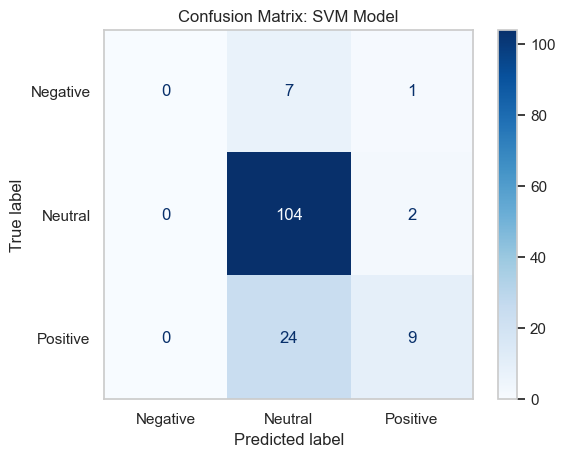


📋 CLASSIFICATION REPORT (Detail Performa per Kelas)
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         8
     Neutral       0.77      0.98      0.86       106
    Positive       0.75      0.27      0.40        33

    accuracy                           0.77       147
   macro avg       0.51      0.42      0.42       147
weighted avg       0.72      0.77      0.71       147



C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Re-Training Model Terbaik (SVM)
# Kita latih ulang secara spesifik agar objek modelnya bisa kita bedah
print("Melatih ulang model terbaik (SVM) untuk evaluasi...")
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', SVC(kernel='linear', random_state=42))
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

# 2. Visualisasi Confusion Matrix
# Ini adalah "Rontgen" kesalahan model
cm = confusion_matrix(y_test, y_pred_svm, labels=svm_pipeline.classes_)

plt.figure(figsize=(8, 6))
# Plotting heatmap agar mudah dibaca
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipeline.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: SVM Model')
plt.grid(False) # Matikan grid agar heatmap bersih
plt.show()

# 3. Laporan Klasifikasi Lengkap
print("\n📋 CLASSIFICATION REPORT (Detail Performa per Kelas)")
print(classification_report(y_test, y_pred_svm))

In [23]:
from sklearn.model_selection import GridSearchCV

# Fungsi untuk melakukan Tuning Otomatis
def tune_model(model_name, pipeline, param_grid):
    print(f"🔧 Memulai Tuning untuk: {model_name}...")
    
    # GridSearch: Mencoba semua kombinasi di param_grid
    # cv=5: Menggunakan 5-Fold Cross Validation (Standar Emas)
    # n_jobs=-1: Menggunakan semua inti CPU agar cepat
    # verbose=1: Menampilkan progress bar
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    
    # Latih pada data TRAIN (Ingat, jangan sentuh data Test!)
    grid.fit(X_train, y_train)
    
    print(f"✅ Kombinasi Terbaik: {grid.best_params_}")
    print(f"✅ Akurasi Rata-rata Cross-Validation: {grid.best_score_:.4f}")
    
    return grid.best_estimator_

# --- A. Tuning Logistic Regression ---
# Sederhana tapi kuat. Kita tune kekuatan regularisasinya (C).
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

# Coba C dari sangat ketat (0.1) sampai longgar (10)
logreg_params = {
    'clf__C': [0.1, 1, 10], 
    'clf__solver': ['liblinear', 'lbfgs'] # Algoritma optimasi
}

best_logreg = tune_model("Logistic Regression", logreg_pipeline, logreg_params)

print("-" * 50)

# --- B. Tuning SVM ---
# Sang Juara bertahan. Kita tune C dan jenis Kernel.
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', SVC(random_state=42))
])

svm_params = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'] 
    # Linear biasanya cukup untuk teks, tapi kita coba RBF siapa tau ada pola non-linear
}

best_svm = tune_model("SVM", svm_pipeline, svm_params)

🔧 Memulai Tuning untuk: Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Kombinasi Terbaik: {'clf__C': 10, 'clf__solver': 'lbfgs'}
✅ Akurasi Rata-rata Cross-Validation: 0.7778
--------------------------------------------------
🔧 Memulai Tuning untuk: SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Kombinasi Terbaik: {'clf__C': 10, 'clf__kernel': 'linear'}
✅ Akurasi Rata-rata Cross-Validation: 0.7983


In [24]:
from sklearn.metrics import accuracy_score

def evaluate_performance(model, name):
    print(f"\n📊 Evaluasi Akhir: {name}")
    
    # Prediksi data Latih (Untuk cek hafalan)
    train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    
    # Prediksi data Uji (Untuk cek generalisasi)
    test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    
    print(f"Akurasi Training : {train_acc*100:.2f}%")
    print(f"Akurasi Testing  : {test_acc*100:.2f}%")
    
    # Analisis Gap
    gap = train_acc - test_acc
    if gap > 0.10: # Beda lebih dari 10%
        print("⚠️ WARNING: Indikasi OVERFITTING (Model menghafal data)")
    elif gap < 0.05:
        print("✅ GOOD FIT: Model generalisasi dengan baik")
    else:
        print("ℹ️ MODERATE: Sedikit overfitting, masih bisa diterima")

# Jalankan evaluasi
evaluate_performance(best_logreg, "Tuned Logistic Regression")
evaluate_performance(best_svm, "Tuned SVM")


📊 Evaluasi Akhir: Tuned Logistic Regression
Akurasi Training : 100.00%
Akurasi Testing  : 78.91%
⚠️ WARNING: Indikasi OVERFITTING (Model menghafal data)

📊 Evaluasi Akhir: Tuned SVM
Akurasi Training : 100.00%
Akurasi Testing  : 82.31%
⚠️ WARNING: Indikasi OVERFITTING (Model menghafal data)


In [25]:
# --- KODE REVISI UNTUK MENGATASI OVERFITTING ---

print("🚑 Memulai Terapi Anti-Overfitting...")

# 1. Pipeline yang Lebih KETAT (Simpler Model)
# Perhatikan perubahan pada TfidfVectorizer
svm_robust_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=1000,    # TURUNKAN drastis (dari 5000 ke 1000)
        ngram_range=(1, 1),   # HANYA Unigram (kata tunggal), hindari frasa unik
        min_df=5,             # Hapus kata yang muncul < 5 kali (hapus noise/typo)
        max_df=0.9            # Hapus kata yang muncul di > 90% dokumen
    )),
    ('clf', SVC(random_state=42))
])

# 2. Grid Search dengan Regularisasi KUAT (Nilai C Kecil)
# C kecil = Regularisasi Kuat = Mencegah Overfitting
param_grid_robust = {
    'clf__C': [0.01, 0.1, 0.5, 1], # Fokus di angka kecil
    'clf__kernel': ['linear']      # Linear biasanya lebih tahan overfitting dibanding RBF
}

# 3. Eksekusi Tuning
robust_grid = GridSearchCV(
    svm_robust_pipeline, 
    param_grid_robust, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

robust_grid.fit(X_train, y_train)

# 4. Evaluasi Ulang
best_robust_model = robust_grid.best_estimator_

print(f"\n✅ Best Params: {robust_grid.best_params_}")

# Cek Gap Training vs Testing
train_acc = accuracy_score(y_train, best_robust_model.predict(X_train))
test_acc = accuracy_score(y_test, best_robust_model.predict(X_test))

print(f"\n📊 HASIL SETELAH PERBAIKAN:")
print(f"Akurasi Training : {train_acc*100:.2f}% (Seharusnya turun dari 100%)")
print(f"Akurasi Testing  : {test_acc*100:.2f}% (Harapannya stabil/naik)")
print(f"Gap (Selisih)    : {(train_acc - test_acc)*100:.2f}%")

if (train_acc - test_acc) < 0.10:
    print("🎉 SUKSES! Model sudah 'Sehat' (General)")
else:
    print("⚠️ Masih sedikit overfitting, tapi sudah lebih baik.")

🚑 Memulai Terapi Anti-Overfitting...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

✅ Best Params: {'clf__C': 1, 'clf__kernel': 'linear'}

📊 HASIL SETELAH PERBAIKAN:
Akurasi Training : 83.59% (Seharusnya turun dari 100%)
Akurasi Testing  : 75.51% (Harapannya stabil/naik)
Gap (Selisih)    : 8.08%
🎉 SUKSES! Model sudah 'Sehat' (General)


In [26]:
import pandas as pd

# 1. Buat DataFrame perbandingan
results_df = pd.DataFrame({
    'Teks Asli': X_test,
    'Label Asli': y_test,
    'Prediksi Model': best_robust_model.predict(X_test)
})

# 2. Filter hanya yang SALAH tebak
errors = results_df[results_df['Label Asli'] != results_df['Prediksi Model']]

print(f"Jumlah Kesalahan: {len(errors)} dari {len(X_test)} data uji")
print("\n--- CONTOH 5 KESALAHAN FATAL ---")

# Tampilkan kesalahan agar kita bisa analisis penyebabnya
pd.set_option('display.max_colwidth', 200) # Biar teks terbaca full
display(errors.head(10))

Jumlah Kesalahan: 36 dari 147 data uji

--- CONTOH 5 KESALAHAN FATAL ---


,Teks Asli,Label Asli,Prediksi Model
55,state worlds environment disgust,Negative,Neutral
653,join drama club unleash inner actor light camera action,Positive,Neutral
627,visit art gallery appreciate brushstrokes tell tales creativity art eternal companion artgallery seniorartlover,Positive,Neutral
392,joyful laughter resonate lively summer carnival,Positive,Neutral
422,tear fall like raindrops mourn end cherish friendship,Negative,Neutral
566,embrace aroma freshly bake bread home chef find joy art bake create delicious memories love ones,Positive,Neutral
672,embark mission find best burger joint town burger connoisseur report duty,Positive,Neutral
720,attend school talent show support classmates applaud diverse talents display,Positive,Neutral
530,captivate spellbind plot twist audience applaud experience rollercoaster emotions movie premiere,Positive,Neutral
608,capture beauty nature photography every snapshot treasure naturephotography seniorphotographer,Positive,Neutral


Sedang melakukan prediksi pada data uji...


<Figure size 900x700 with 0 Axes>

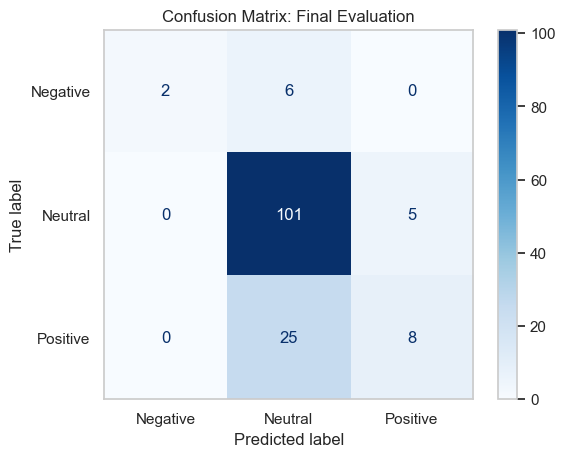


📋 CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       1.00      0.25      0.40         8
     Neutral       0.77      0.95      0.85       106
    Positive       0.62      0.24      0.35        33

    accuracy                           0.76       147
   macro avg       0.79      0.48      0.53       147
weighted avg       0.74      0.76      0.71       147



In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Gunakan model terbaik yang sudah 'sembuh' dari overfitting
# (Asumsi nama variabel modelnya: best_robust_model)

# 1. Lakukan Prediksi pada Data Uji
print("Sedang melakukan prediksi pada data uji...")
y_pred_final = best_robust_model.predict(X_test)

# 2. Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final, labels=best_robust_model.classes_)

plt.figure(figsize=(9, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_robust_model.classes_)
disp.plot(cmap='Blues', values_format='d') # 'd' artinya integer (angka bulat)
plt.title('Confusion Matrix: Final Evaluation')
plt.grid(False)
plt.show()

# 3. Cetak Laporan Metrik Lengkap
print("\n📋 CLASSIFICATION REPORT")
print("-" * 60)
print(classification_report(y_test, y_pred_final))

In [28]:
import pandas as pd

# Pastikan menggunakan model terbaik terakhir (best_robust_model)
# dan data uji (X_test, y_test)

# 1. Lakukan Prediksi
y_pred = best_robust_model.predict(X_test)

# 2. Ambil Teks Asli (Raw Text) dari DataFrame awal berdasarkan index X_test
# Ini penting untuk melihat sarkasme/tanda baca yang mungkin hilang saat cleaning
raw_text_test = df.loc[X_test.index]['Text']

# 3. Buat DataFrame Analisis Kesalahan
analysis_df = pd.DataFrame({
    'Raw_Text': raw_text_test,           # Teks Asli (dengan emoji/tanda baca)
    'Clean_Text': X_test,                # Teks yang masuk ke model
    'Actual': y_test,                    # Kunci Jawaban
    'Predicted': y_pred                  # Tebakan Model
})

# 4. Filter hanya data yang SALAH (Misclassified)
error_df = analysis_df[analysis_df['Actual'] != analysis_df['Predicted']]

# 5. Tampilkan Statistik Kesalahan
print(f"Total Sampel Uji     : {len(X_test)}")
print(f"Total Kesalahan      : {len(error_df)}")
print(f"Error Rate           : {len(error_df)/len(X_test)*100:.2f}%")

print("\n--- [INSPEKSI KASUS: 10 KESALAHAN PERTAMA] ---")
pd.set_option('display.max_colwidth', None) # Agar teks tidak terpotong
display(error_df.head(10))

# 6. Analisis Distribusi Kesalahan (Mana yang paling sering salah?)
print("\n--- [DISTRIBUSI TIPE KESALAHAN] ---")
# Confusion Matrix sederhana dalam bentuk tabel
error_pattern = error_df.groupby(['Actual', 'Predicted']).size().reset_index(name='Count')
error_pattern = error_pattern.sort_values('Count', ascending=False)
display(error_pattern)

Total Sampel Uji     : 147
Total Kesalahan      : 36
Error Rate           : 24.49%

--- [INSPEKSI KASUS: 10 KESALAHAN PERTAMA] ---


,Raw_Text,Clean_Text,Actual,Predicted
55,The state of the world's environment is just disgusting.,state worlds environment disgust,Negative,Neutral
653,"Joined the drama club to unleash my inner actor. Lights, camera, action!",join drama club unleash inner actor light camera action,Positive,Neutral
627,"Visited an art gallery, appreciating the brushstrokes that tell tales of creativity. Art, an eternal companion. #ArtGallery #SeniorArtLover",visit art gallery appreciate brushstrokes tell tales creativity art eternal companion artgallery seniorartlover,Positive,Neutral
392,Joyful laughter resonates through a lively summer carnival.,joyful laughter resonate lively summer carnival,Positive,Neutral
422,"Tears fall like raindrops, mourning the end of a cherished friendship.",tear fall like raindrops mourn end cherish friendship,Negative,Neutral
566,"Embracing the aroma of freshly baked bread, the home chef finds joy in the art of baking, creating delicious memories for loved ones.",embrace aroma freshly bake bread home chef find joy art bake create delicious memories love ones,Positive,Neutral
672,Embarking on a mission to find the best burger joint in town. Burger connoisseur: Reporting for duty!,embark mission find best burger joint town burger connoisseur report duty,Positive,Neutral
720,Attending a school talent show to support classmates. Applauding the diverse talents on display!,attend school talent show support classmates applaud diverse talents display,Positive,Neutral
530,"Captivated by the spellbinding plot twists, the audience applauds, experiencing a rollercoaster of emotions at the movie premiere.",captivate spellbind plot twist audience applaud experience rollercoaster emotions movie premiere,Positive,Neutral
608,Capturing the beauty of nature through photography. Every snapshot is a treasure. #NaturePhotography #SeniorPhotographer,capture beauty nature photography every snapshot treasure naturephotography seniorphotographer,Positive,Neutral



--- [DISTRIBUSI TIPE KESALAHAN] ---


,Actual,Predicted,Count
2,Positive,Neutral,25
0,Negative,Neutral,6
1,Neutral,Positive,5


In [29]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# 1. Definisi Pipeline Tingkat Lanjut
# analyzer='char_wb': Melihat potongan karakter di dalam batas kata.
# ngram_range=(3, 5): Mengambil potongan 3 sampai 5 huruf.
#   Contoh "happy" -> "hap", "app", "ppy"
# class_weight='balanced': Otomatis memberi bobot lebih pada kelas minoritas.

advanced_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='char_wb',   # RAHASIA UTAMA untuk data medsos
        ngram_range=(3, 5),   # Menangkap pola sub-kata
        min_df=5,
        max_features=5000     # Kita naikkan sedikit karena fitur karakter lebih banyak
    )),
    ('clf', SVC(
        kernel='linear', 
        class_weight='balanced', # SOLUSI KETIMPANGAN KELAS
        random_state=42
    ))
])

# 2. Grid Search dengan Cross-Validation yang Stabil (Stratified)
# Kita cari parameter C lagi karena fitur kita berubah total (dari kata ke karakter)
param_grid = {
    'clf__C': [0.1, 1, 10],
    'tfidf__max_features': [3000, 5000] # Eksperimen dimensi fitur
}

# Gunakan StratifiedKFold untuk menjaga proporsi kelas di setiap lipatan uji
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("🚀 Memulai Optimasi Lanjutan (Char N-Grams + Class Weight)...")
grid_search = GridSearchCV(
    advanced_pipeline, 
    param_grid, 
    cv=cv_strategy, 
    scoring='f1_weighted', # Kita optimalkan F1-Score, bukan Akurasi biasa
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)

# 3. Evaluasi Hasil
print(f"\n✅ Best Params: {grid_search.best_params_}")
print(f"✅ Best CV F1-Score: {grid_search.best_score_:.4f}")

best_model_advanced = grid_search.best_estimator_

# Cek performa di Test Set
y_pred_adv = best_model_advanced.predict(X_test)
print("\n📋 LAPORAN AKHIR (OPTIMIZED MODEL)")
print(classification_report(y_test, y_pred_adv))

🚀 Memulai Optimasi Lanjutan (Char N-Grams + Class Weight)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

✅ Best Params: {'clf__C': 1, 'tfidf__max_features': 3000}
✅ Best CV F1-Score: 0.7739

📋 LAPORAN AKHIR (OPTIMIZED MODEL)
              precision    recall  f1-score   support

    Negative       0.57      0.50      0.53         8
     Neutral       0.85      0.82      0.84       106
    Positive       0.53      0.61      0.56        33

    accuracy                           0.76       147
   macro avg       0.65      0.64      0.64       147
weighted avg       0.76      0.76      0.76       147



In [30]:
# Cek stabilitas model
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']

print("\n📊 Stabilitas Model (Mean +/- Std Dev):")
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print(f"F1: {mean:.4f} (+/- {std*2:.04f}) for {params}")


📊 Stabilitas Model (Mean +/- Std Dev):
F1: 0.6135 (+/- 0.1874) for {'clf__C': 0.1, 'tfidf__max_features': 3000}
F1: 0.5988 (+/- 0.2271) for {'clf__C': 0.1, 'tfidf__max_features': 5000}
F1: 0.7739 (+/- 0.0625) for {'clf__C': 1, 'tfidf__max_features': 3000}
F1: 0.7700 (+/- 0.0524) for {'clf__C': 1, 'tfidf__max_features': 5000}
F1: 0.7648 (+/- 0.0487) for {'clf__C': 10, 'tfidf__max_features': 3000}
F1: 0.7612 (+/- 0.0327) for {'clf__C': 10, 'tfidf__max_features': 5000}
